In [31]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from scipy.stats import entropy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import socket, struct

import imblearn
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import LabelEncoder
from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline
from imblearn.under_sampling import NearMiss
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.utils import class_weight
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
from scipy.spatial.distance import jensenshannon
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder



In [32]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [33]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [34]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Normal
import numpy as np


In [35]:
filepath = "/content/drive/MyDrive/Colab Notebooks/1st.csv"
df = pd.read_csv(filepath, header=None)

In [36]:
columns = [
    'duration', 'min_fiat', 'min_biat', 'max_fiat', 'max_biat', 'mean_fiat', 'mean_biat',
    'std_fiat', 'std_biat', 'flowPktsPerSecond', 'flowBytesPerSecond', 'min_flowiat',
    'max_flowiat', 'mean_flowiat', 'std_flowiat', 'min_active', 'mean_active', 'max_active',
    'std_active', 'min_idle', 'mean_idle', 'max_idle', 'std_idle', 'class1'
]
df.columns = columns

# Inspect the data
df.head()

,duration,min_fiat,min_biat,max_fiat,max_biat,mean_fiat,mean_biat,std_fiat,std_biat,flowPktsPerSecond,...,std_flowiat,min_active,mean_active,max_active,std_active,min_idle,mean_idle,max_idle,std_idle,class1
0,76,-1,-1,-1,-1,0.0,0.0,0.0,0.0,26315.789474,...,0.0,-1,0.0,-1,0.0,-1,0.0,-1,0.0,CHAT
1,54,-1,-1,-1,-1,0.0,0.0,0.0,0.0,37037.037037,...,0.0,-1,0.0,-1,0.0,-1,0.0,-1,0.0,CHAT
2,67,-1,-1,-1,-1,0.0,0.0,0.0,0.0,29850.746269,...,0.0,-1,0.0,-1,0.0,-1,0.0,-1,0.0,CHAT
3,75,-1,-1,-1,-1,0.0,0.0,0.0,0.0,26666.666667,...,0.0,-1,0.0,-1,0.0,-1,0.0,-1,0.0,CHAT
4,14512571,14512571,-1,14512571,-1,14500000.0,0.0,0.0,0.0,0.206717,...,10300000.0,14512571,14500000.0,14512571,0.0,14512502,14500000.0,14512502,0.0,CHAT


In [37]:
X = df[df.columns[:-1]]
y = df['class1']

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Encode the labels
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2)


In [38]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(12412, 23)
(3103, 23)
(12412,)
(3103,)


In [40]:

class BayesianLinear(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features

        # Weight parameters
        self.weight_mu = nn.Parameter(torch.Tensor(out_features, in_features).uniform_(-0.2, 0.2))
        self.weight_rho = nn.Parameter(torch.Tensor(out_features, in_features).uniform_(-5, -4))

        # Bias parameters
        self.bias_mu = nn.Parameter(torch.Tensor(out_features).uniform_(-0.2, 0.2))
        self.bias_rho = nn.Parameter(torch.Tensor(out_features).uniform_(-5, -4))

    def forward(self, input):
        weight_sigma = torch.log1p(torch.exp(self.weight_rho))
        bias_sigma = torch.log1p(torch.exp(self.bias_rho))

        weight = Normal(self.weight_mu, weight_sigma).rsample()
        bias = Normal(self.bias_mu, bias_sigma).rsample()

        return F.linear(input, weight, bias)

class BayesianMLP(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super().__init__()
        self.hidden1 = BayesianLinear(input_size, hidden_size)
        self.hidden2 = BayesianLinear(hidden_size, hidden_size)
        self.out = BayesianLinear(hidden_size, num_classes)

    def forward(self, x):
        x = F.relu(self.hidden1(x))
        x = F.relu(self.hidden2(x))
        return self.out(x)

In [41]:
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

# Define constants
input_size = 23
hidden_size = 128  # Increased hidden size
num_classes = len(torch.unique(y_train))

In [42]:
model = BayesianMLP(input_size, hidden_size, num_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

num_epochs = 100
batch_size = 64

for epoch in range(num_epochs):
    for i in range(0, len(X_train), batch_size):
        batch_X = X_train[i:i+batch_size]
        batch_y = y_train[i:i+batch_size]

        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Evaluate the model

Epoch [10/100], Loss: 1.0852
Epoch [20/100], Loss: 1.0377
Epoch [30/100], Loss: 0.9639
Epoch [40/100], Loss: 0.8316
Epoch [50/100], Loss: 0.8362
Epoch [60/100], Loss: 0.7689
Epoch [70/100], Loss: 0.8417
Epoch [80/100], Loss: 0.7667
Epoch [90/100], Loss: 0.7453
Epoch [100/100], Loss: 0.7123


In [43]:
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    outputs = model(X_test)
    _, predicted = torch.max(outputs.data, 1)
    total += y_test.size(0)
    correct += (predicted == y_test).sum().item()
    print(f'Accuracy on the test set: {100 * correct / total:.2f}%')

Accuracy on the test set: 70.51%


In [44]:
newval=X_test[0]

In [45]:
newval_out=y_test[0]

In [22]:
model.eval()

# Select the input value you want to predict
newval = X_test[0].unsqueeze(0)  # Add a batch dimension

# Predict the output
with torch.no_grad():
    output = model(newval)
    prediction = F.softmax(output, dim=1)
    predicted_class = torch.argmax(prediction).item()

# Print the prediction and predicted class
print(f"Output probabilities: {prediction}")
print(f"Predicted class: {predicted_class}")

Output probabilities: tensor([[7.9234e-01, 2.2697e-02, 2.7440e-02, 1.5582e-01, 2.0417e-08, 2.9939e-04,
         1.4010e-03]])
Predicted class: 0


In [23]:
model.eval()

# Select the input value you want to predict
newval = X_test[0].unsqueeze(0)  # Add a batch dimension

# Predict the output
with torch.no_grad():
    output = model(newval)
    prediction = F.softmax(output, dim=1)
    predicted_class = torch.argmax(prediction).item()

# Print the prediction and predicted class
print(f"Output probabilities: {prediction}")
print(f"Predicted class: {predicted_class}")

Output probabilities: tensor([[6.0871e-01, 6.9431e-02, 4.9159e-02, 2.7110e-01, 6.7977e-08, 3.1874e-04,
         1.2720e-03]])
Predicted class: 0


In [24]:
def instability_check(model, x, num_samples=2, threshold=0.1):
    model.eval()
    outputs = []

    for _ in range(num_samples):
        with torch.no_grad():
            outputs.append(F.softmax(model(x), dim=1))

    outputs = torch.stack(outputs)
    mean_output = outputs.mean(dim=0)

    js_divergence = 0.5 * F.kl_div(outputs[0].log(), mean_output, reduction='batchmean') + \
                    0.5 * F.kl_div(outputs[1].log(), mean_output, reduction='batchmean')

    instability = torch.sqrt(js_divergence)

    return instability.item() > threshold

In [25]:
def familiarity_based_filtering(model, X, lambda_factor=1.0, beta_2=0.5):
    model.eval()
    familiarities = []

    for x in X:
        x = x.unsqueeze(0)

        # Compute confidence
        with torch.no_grad():
            output = model(x)
        confidence = F.softmax(output, dim=1).max().item()

        # Compute instability
        instability = instability_check(model, x, num_samples=2, threshold=1.0)  # We want the actual value, not boolean

        # Compute familiarity
        familiarity = (lambda_factor * (confidence - beta_2) - instability) / np.sqrt(lambda_factor**2 + 1)
        familiarities.append(familiarity)

    familiarities = np.array(familiarities)

    # Filter packets with negative familiarity scores
    unknown_indices = np.where(familiarities < 0)[0]

    return unknown_indices, familiarities

In [26]:
def update_model(model, X_new, y_new, num_epochs=10, lr=0.001):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    model.train()
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        output = model(X_new)
        loss = criterion(output, y_new)
        loss.backward()
        optimizer.step()

        if (epoch + 1) % 5 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

    return model

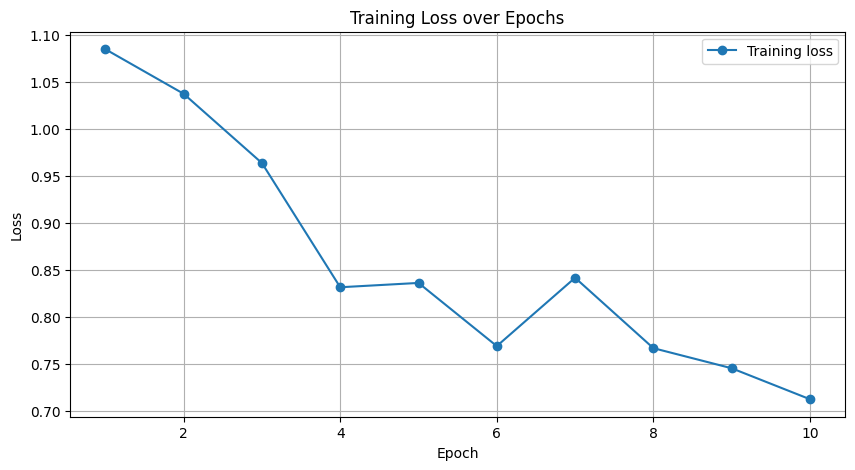

In [46]:
import matplotlib.pyplot as plt

# Assuming you have stored losses during training
# Replace 'losses' with your actual list of losses
losses = [1.0852, 1.0377, 0.9639, 0.8316, 0.8362, 0.7689, 0.8417, 0.7667, 0.7453, 0.7123]
epochs = range(1, len(losses) + 1)

plt.figure(figsize=(10, 5))
plt.plot(epochs, losses, '-o', label='Training loss')
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

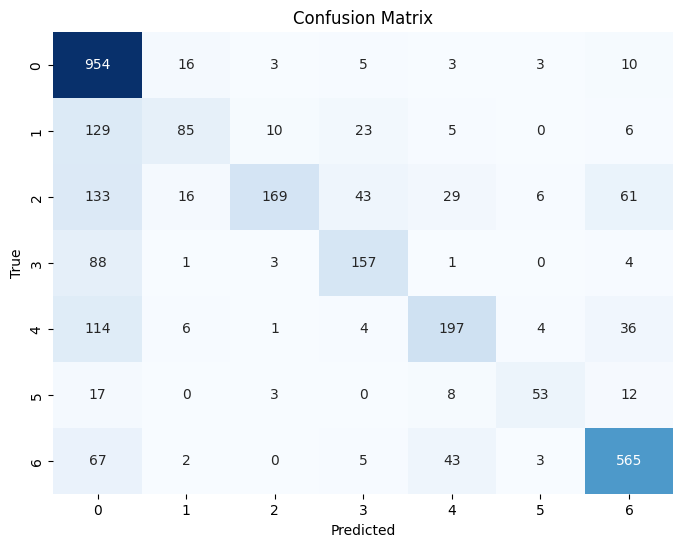

In [47]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

model.eval()
with torch.no_grad():
    outputs = model(X_test)
    _, predicted = torch.max(outputs, 1)
    cm = confusion_matrix(y_test, predicted)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

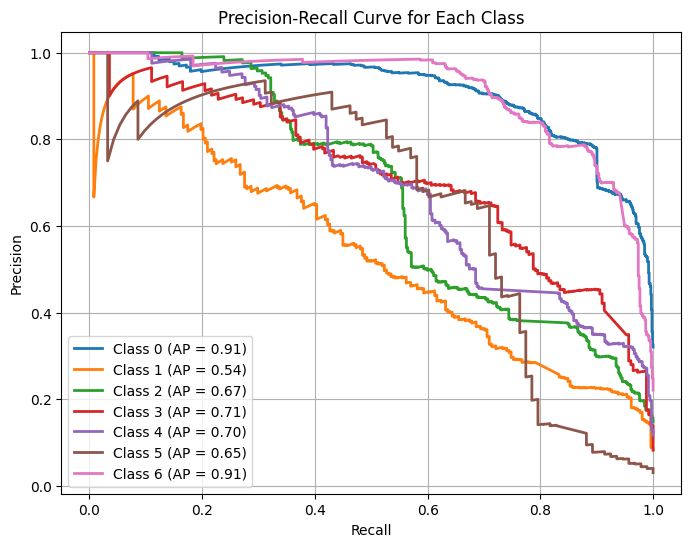

In [51]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import numpy as np

model.eval()
with torch.no_grad():
    outputs = model(X_test)
    probs = torch.nn.functional.softmax(outputs, dim=1).numpy()

# Example assuming binary classification, adjust for multiclass if needed
precision = dict()
recall = dict()
average_precision = dict()
for i in range(num_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test == i, probs[:, i])
    average_precision[i] = average_precision_score(y_test == i, probs[:, i])

plt.figure(figsize=(8, 6))
for i in range(num_classes):
    plt.plot(recall[i], precision[i], lw=2, label=f'Class {i} (AP = {average_precision[i]:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Each Class')
plt.legend(loc='best')
plt.grid(True)
plt.show()